# SCR analysis for the NFC project

In this notebook we will:

1. load the csv file and get 

    1.1 get stim type

2. load scr file

3. plot scr

4. fit the csv to the scr

In [1]:
import neurokit2 as nk
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [500, 10]  # Bigger images

### Load participants csv file and get stim and onsets


In [132]:
csv = pd.read_csv('pilot/subj/nFC14_112202115517.csv', error_bad_lines=False)
csv = csv.dropna(subset=['onset'])
stims = csv.stim.tolist()

/home/nachshon/anaconda3/envs/nfc/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


### Load scr file

In [133]:
scr_file = 'pilot/scr/8.acq'
eda_signal, sampling_rate = nk.read_acqknowledge(scr_file, sampling_rate=128, 
                                               resample_method="interpolation", impute_missing=True)

<AxesSubplot:>

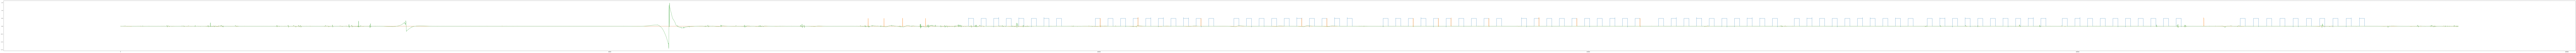

In [134]:
eda_signal['stim'] = eda_signal.Stimulus/10
eda_signal['shock'] = eda_signal.Shock/10

eda_signal.stim.plot(figsize = (500,10))
eda_signal.shock.plot(figsize = (500,10))
signals.EDA_Phasic.plot(figsize = (500,10))

EDA processing

In [135]:
signals, info = nk.eda_process(eda_signal.iloc[:,1], sampling_rate=sampling_rate)
features = [info["SCR_Onsets"], info["SCR_Peaks"], info["SCR_Recovery"]]
events = nk.events_find(event_channel=eda_signal.iloc[:,2], event_conditions = stims)
shocks = nk.events_find(event_channel=eda_signal.iloc[:,3], threshold_keep='bellow')
print("events: " + str(len(events['onset'])) +" shocks: " +  str(len(shocks['onset'])))

events: 98 shocks: 18


In [136]:
epochs = nk.epochs_create(signals, events, sampling_rate=sampling_rate, 
                              epochs_start=1, epochs_end=8.5, 
                              event_conditions = stims)
results = nk.bio_analyze(epochs, sampling_rate=sampling_rate, method='event-related')

In [137]:
results.Condition = pd.Categorical(results.Condition,
                    categories=results.Condition.unique())


condIDX = results.Condition.cat.codes.values
results.Condition.value_counts()

CSminus     44
CSplus      32
CSplusUS    12
self        10
Name: Condition, dtype: int64

In [138]:
results.groupby('Condition').mean('EDA_Peak_Amplitude')

,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
Condition,,,,,,,
CSminus,149142.840909,0.012779,0.022727,0.223357,8.187174,0.562500,937.0
CSplus,158316.312500,0.014683,0.000000,NaN,NaN,NaN,NaN
CSplusUS,128813.416667,0.014225,0.000000,NaN,NaN,NaN,NaN
self,222839.200000,0.017845,0.100000,0.234018,2.188738,0.367188,211.0


Condition
CSminus     AxesSubplot(0.125,0.125;0.775x0.755)
CSplus      AxesSubplot(0.125,0.125;0.775x0.755)
CSplusUS    AxesSubplot(0.125,0.125;0.775x0.755)
self        AxesSubplot(0.125,0.125;0.775x0.755)
Name: EDA_Peak_Amplitude, dtype: object

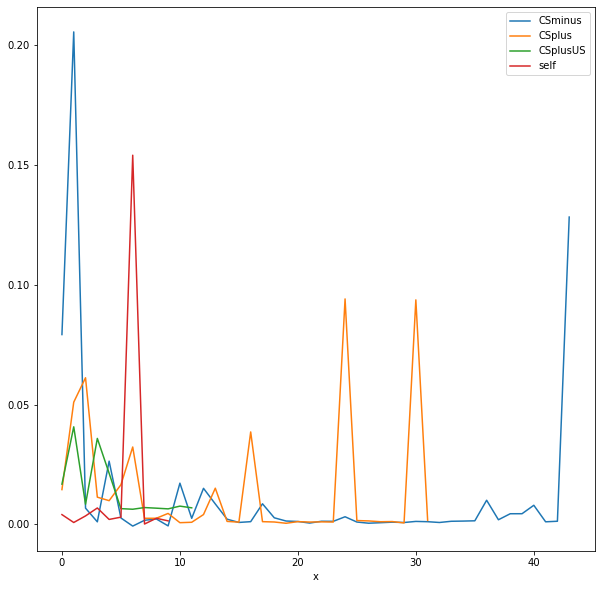

In [139]:
x = []
for i in range(len(condIDX)):
    x.append(np.count_nonzero(condIDX[:i] == condIDX[i]))
    
results['x']=x
results.set_index('x', inplace=True)
results.groupby('Condition')['EDA_Peak_Amplitude'].plot(legend=True, figsize = (10,10))